In [128]:
'''Main'''
import json
import pandas as pd
import string
import re
import time
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import os
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from keras.callbacks import ModelCheckpoint

## Import data set

Train Data

In [204]:
trainList = []
print("Started Reading JSON file which contains multiple JSON document")
with open("train.json", "r") as f:
    for jsonObj in f:
        trainDict = json.loads(jsonObj)
        trainList.append(trainDict)
        
trainDF = pd.DataFrame(data = trainList)
trainDF.info()
trainDF.head()

Started Reading JSON file which contains multiple JSON document
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         200000 non-null  float64
 1   reviewTime      200000 non-null  object 
 2   reviewerID      200000 non-null  object 
 3   reviewText      199964 non-null  object 
 4   summary         199965 non-null  object 
 5   unixReviewTime  200000 non-null  int64  
 6   category        200000 non-null  object 
 7   price           200000 non-null  object 
 8   itemID          200000 non-null  object 
 9   reviewHash      200000 non-null  object 
 10  image           463 non-null     object 
dtypes: float64(1), int64(1), object(9)
memory usage: 16.8+ MB


,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,4.0,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,NaN
1,5.0,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,NaN
2,4.0,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,NaN
3,5.0,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,NaN
4,4.0,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,NaN


Test Data

In [205]:
testList = []
print("Started Reading JSON file which contains multiple JSON document")
with open("test.json", "r") as f:
    for jsonObj in f:
        testDict = json.loads(jsonObj)
        testList.append(testDict)
        
testDF = pd.DataFrame(data = testList)
testDF.info()
testDF.head()

Started Reading JSON file which contains multiple JSON document
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewTime      10000 non-null  object
 1   reviewerID      10000 non-null  object
 2   reviewText      9999 non-null   object
 3   summary         9998 non-null   object
 4   unixReviewTime  10000 non-null  int64 
 5   category        10000 non-null  object
 6   price           10000 non-null  object
 7   itemID          10000 non-null  object
 8   reviewHash      10000 non-null  object
 9   image           23 non-null     object
dtypes: int64(1), object(9)
memory usage: 781.4+ KB


,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,"03 26, 2015",u32476110,"Fantastic mix of ""old school"" with a creative ...","Fantastic mix of ""old school"" with a creative ...",1427328000,Pop,$14.98,p76243483,20167847,NaN
1,"05 15, 2017",u36732410,Update: Indications\nThere are various opinion...,Digitally Extracted Stereo (DES) Rules!,1494806400,Pop,$15.16,p92485419,30527605,NaN
2,"06 4, 2015",u85385007,This album provides a new twist on old Sammy H...,Excellent unplugged album,1433376000,Pop,$7.37,p40031588,12169432,NaN
3,"04 23, 2009",u30715529,(Symbol) can be considered as another masterpi...,another masterpiece,1240444800,Pop,$12.45,p88719785,55648615,NaN
4,"09 15, 2000",u95909892,Many would think this album is good only becau...,True Classic Rock,968976000,Alternative Rock,$2.07,p59188380,09520938,NaN


## Exploratory analysis & Preprocessing

In [206]:
trainDF = trainDF[['reviewerID','itemID','overall']]
trainDF.head()

,reviewerID,itemID,overall
0,u04428712,p70761125,4.0
1,u06946603,p85427891,5.0
2,u92735614,p82172532,4.0
3,u35112935,p15255251,5.0
4,u07141505,p82618188,4.0


In [207]:
trainDF.groupby(['reviewerID','itemID']).size()

reviewerID  itemID   
u00000217   p08261224    1
            p51080352    1
            p76782930    1
            p92904252    1
u00002652   p31717620    1
                        ..
u99998688   p35178845    1
            p60861164    1
            p74186509    1
u99999649   p10581538    1
            p51430573    1
Length: 200000, dtype: int64

<AxesSubplot:>

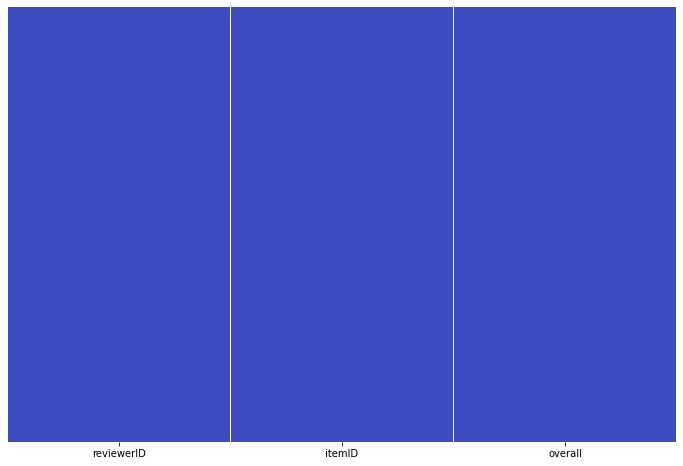

In [208]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(trainDF.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

In [209]:
testDF = testDF[['reviewerID','itemID']]
testDF.head()

,reviewerID,itemID
0,u32476110,p76243483
1,u36732410,p92485419
2,u85385007,p40031588
3,u30715529,p88719785
4,u95909892,p59188380


In [210]:
testDF.groupby(['reviewerID','itemID']).size()

reviewerID  itemID   
u00002652   p87874123    1
u00005892   p64166735    1
u00008314   p53859222    1
u00016592   p10232162    1
u00030542   p03849162    1
                        ..
u99983493   p40902042    1
            p46136589    1
u99996166   p73415113    1
            p73613056    1
            p89434408    1
Length: 10000, dtype: int64

<AxesSubplot:>

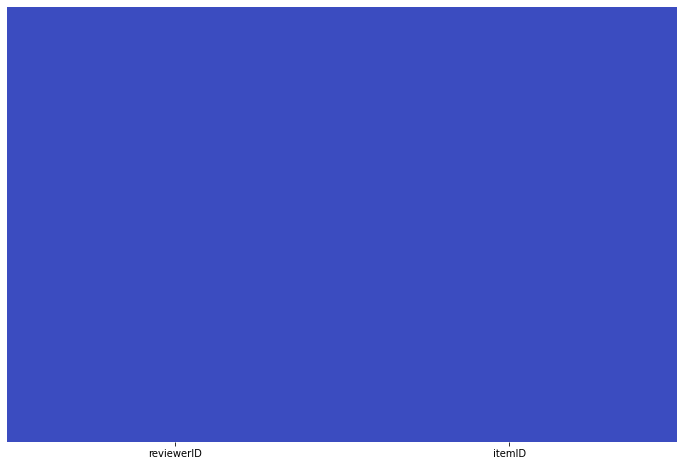

In [211]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(testDF.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

In [212]:
# tarining set basic statistics
n_users = trainDF.reviewerID.unique().shape[0]
n_items = trainDF.itemID.unique().shape[0]
n_ratings = len(trainDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique items: ', n_items)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  72285
Number of unique items:  25493
Number of total ratings:  200000
Average number of ratings per user:  2.766825759147818


In [213]:
trainDF

,reviewerID,itemID,overall
0,u04428712,p70761125,4.0
1,u06946603,p85427891,5.0
2,u92735614,p82172532,4.0
3,u35112935,p15255251,5.0
4,u07141505,p82618188,4.0
...,...,...,...
199995,u68902609,p84118731,4.0
199996,u15269603,p08613950,5.0
199997,u25124021,p25341819,3.0
199998,u04485604,p19134748,5.0


In [118]:
# encode labels of managers and stocks to start from 0 with LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()

le1.fit(trainDF['reviewerID'])
userDF = le1.transform(trainDF['reviewerID'])

le2.fit(trainDF['itemID'])
itemDF = le2.transform(trainDF['itemID'])

In [214]:
trainDF_enc = pd.DataFrame(data = {'reviewerID':userDF, 'itemID':itemDF,  'rating':trainDF['overall']})

In [215]:
# split the training data into train and validation set
train, val = train_test_split(trainDF_enc,test_size=0.20,shuffle=True, random_state = 42)

In [216]:
# Confirm size of train, validation, and test datasets
print('Size of train set: ', len(train))
print('Size of validation set: ', len(val))
print('Size of test set: ', len(testDF))

Size of train set:  160000
Size of validation set:  40000
Size of test set:  10000


In [217]:
train

,reviewerID,itemID,rating
153248,2610,2677,5.0
67802,34471,23252,5.0
148889,65639,6727,5.0
103093,35150,19110,5.0
104681,25756,14989,5.0
...,...,...,...
119879,53250,9865,4.0
103694,305,24050,5.0
131932,22562,12790,5.0
146867,22551,8259,5.0


In [218]:
# Recommender System using Matrix Factorization (NMF)
# 2 Latent Factor

In [136]:
n_latent_factors = 2

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

item_input = Input(shape=[1], name='item')
item_embedding = Embedding(input_dim=n_items + 1, \
                            output_dim=n_latent_factors,
                            name='item_embedding')(item_input)
item_vec = Flatten(name='flatten_items')(item_embedding)

product = dot([item_vec, user_vec], axes=1)
model = Model(inputs=[user_input, item_input], outputs=product)
model.compile(optimizer='adam', loss='mse', metrics='mean_squared_error')

In [137]:
%%time
checkpoint_filepath = "userID_embeddingModel.hdf5"
callbacks = ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
history = model.fit(x=[train.reviewerID, train.itemID], \
                    y=train.rating, epochs=50, \
                    validation_data=([val.reviewerID, \
                    val.itemID], val.rating), \
                    verbose=1, callbacks = callbacks)
model.load_weights(checkpoint_filepath)

Epoch 1/50
4990/5000 [============================>.] - ETA: 0s - loss: 20.4382 - mean_squared_error: 20.4382
Epoch 00001: val_loss improved from -inf to 20.42263, saving model to userID_embeddingModel.hdf5
5000/5000 [==============================] - 6s 1ms/step - loss: 20.4392 - mean_squared_error: 20.4392 - val_loss: 20.4226 - val_mean_squared_error: 20.4226
Epoch 2/50
5000/5000 [==============================] - ETA: 0s - loss: 20.3658 - mean_squared_error: 20.3658
Epoch 00002: val_loss did not improve from 20.42263
5000/5000 [==============================] - 6s 1ms/step - loss: 20.3658 - mean_squared_error: 20.3658 - val_loss: 20.3747 - val_mean_squared_error: 20.3747
Epoch 3/50
4959/5000 [============================>.] - ETA: 0s - loss: 20.0769 - mean_squared_error: 20.0769
Epoch 00003: val_loss did not improve from 20.42263
5000/5000 [==============================] - 5s 1ms/step - loss: 20.0755 - mean_squared_error: 20.0755 - val_loss: 20.2275 - val_mean_squared_error: 20.227

Minimum MSE:  18.390094757080078


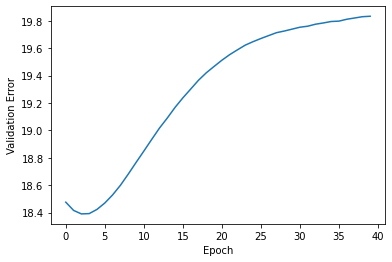

In [138]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [141]:
model.predict(x=[val.reviewerID, val.itemID])

array([[ 0.00506126],
       [-0.00094669],
       [ 0.00085441],
       ...,
       [-0.00192852],
       [-0.00204687],
       [ 0.00616919]], dtype=float32)

## Using Surprise Library

In [2]:
from surprise import Dataset 
from surprise import Reader
# from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV, KFold
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import SVD
from surprise import NMF

In [219]:
# split the training data into train and validation set
train, val = train_test_split(trainDF,test_size=0.20,shuffle=True, random_state = 42)

In [220]:
# Loading as Surprise dataframe and train-test split
reader = Reader(rating_scale = (0,5))
train_holdings = Dataset.load_from_df(train, reader)
train_set = train_holdings.build_full_trainset()

val_holdings = Dataset.load_from_df(val, reader)
val_set = val_holdings.build_full_trainset()

In [221]:
#Fitting NMF model
nmf_model = NMF(random_state = 42)
nmf_model.fit(train_set)

In [222]:
%%time
#Evaluating results
train_predictions = nmf_model.test(train_set.build_testset())
val_predictions = nmf_model.test(val_set.build_testset())
print("RMSE on training data : ", accuracy.mse(train_predictions, verbose = False))
print("RMSE on val data: ", accuracy.mse(val_predictions, verbose = False))

RMSE on training data :  0.06420182644171808
RMSE on val data:  1.34713929888337
Wall time: 3.01 s


In [298]:
%%time
#Hyperparameter tuning for NMF
param_distributions  = {'n_factors': list(range(10,20,2)),'reg_pu': np.arange(0.02,0.2,0.02),'reg_qi': np.arange(0.02,0.2,0.02), 'n_epochs' : [30]}
rs = RandomizedSearchCV(NMF, param_distributions, measures=['rmse'], return_train_measures = True, cv = 5, n_iter = 20)
rs.fit(train_holdings)
rs.best_params['rmse']

Wall time: 15min 30s


{'n_factors': 18, 'reg_pu': 0.1, 'reg_qi': 0.08, 'n_epochs': 30}

In [300]:
tuned_nmf_model = NMF(n_factors=18, reg_pu = 0.1, reg_qi = 0.08, n_epochs = 30, random_state = 42)
tuned_nmf_model.fit(train_set)

## Predict on Test Set

In [301]:
testDF['ratings'] = 0
testDF

,reviewerID,itemID,ratings
0,u32476110,p76243483,0
1,u36732410,p92485419,0
2,u85385007,p40031588,0
3,u30715529,p88719785,0
4,u95909892,p59188380,0
...,...,...,...
9995,u75493520,p47578844,0
9996,u85298918,p49438960,0
9997,u73735798,p85068973,0
9998,u67631525,p59188380,0


In [302]:
test_holdings = Dataset.load_from_df(testDF, reader)
test_set = test_holdings.build_full_trainset()

In [303]:
test_predictions = tuned_nmf_model.test(test_set.build_testset(),verbose=False)

In [304]:
test_predictions[:5]

[Prediction(uid='u32476110', iid='p76243483', r_ui=0.0, est=3.2410771940288625, details={'was_impossible': False}),
 Prediction(uid='u36732410', iid='p92485419', r_ui=0.0, est=3.725365187707972, details={'was_impossible': False}),
 Prediction(uid='u36732410', iid='p80578391', r_ui=0.0, est=3.4926588175566233, details={'was_impossible': False}),
 Prediction(uid='u85385007', iid='p40031588', r_ui=0.0, est=3.7625081210700078, details={'was_impossible': False}),
 Prediction(uid='u85385007', iid='p45159255', r_ui=0.0, est=4.103156866420433, details={'was_impossible': False})]

### Format prediction

In [305]:
# create and merge dataframe to match the prediction sequence to the original index in the given rating_pairs.csv
ui_pair = [pred[0]+'-'+pred[1] for pred in test_predictions]
est_ratings = [pred[3] for pred in test_predictions] 

rrpDF = pd.DataFrame(data = {'userID-itemID':ui_pair, 'prediction':est_ratings})

# original rating_pairs
rpDF = pd.read_csv('rating_pairs.csv')

In [306]:
outDF = rpDF.merge(rrpDF,how='left',left_on='userID-itemID',right_on='userID-itemID')

In [307]:
rpDF

,userID-itemID,prediction
0,u32476110-p76243483,NaN
1,u36732410-p92485419,NaN
2,u85385007-p40031588,NaN
3,u30715529-p88719785,NaN
4,u95909892-p59188380,NaN
...,...,...
9995,u75493520-p47578844,NaN
9996,u85298918-p49438960,NaN
9997,u73735798-p85068973,NaN
9998,u67631525-p59188380,NaN


In [308]:
outDF['prediction'] = outDF.prediction_y
outDF= outDF[['userID-itemID','prediction']]

In [309]:
outDF

,userID-itemID,prediction
0,u32476110-p76243483,3.241077
1,u36732410-p92485419,3.725365
2,u85385007-p40031588,3.762508
3,u30715529-p88719785,4.904635
4,u95909892-p59188380,4.409825
...,...,...
9995,u75493520-p47578844,3.925957
9996,u85298918-p49438960,4.374546
9997,u73735798-p85068973,4.764918
9998,u67631525-p59188380,5.000000


In [310]:
outDF.to_csv('rating_prediction.csv',index=False)

In [311]:
# kaggle score 1.31322